# import library

In [1]:
import librosa, IPython, datetime, time, os, sys, copy, dill, pickle, mir_eval, glob
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform
import IPython.display as ipd
#from datetime import datetime
from time import gmtime, strftime
#from imageio import imread as imread
#from imageio import imsave as imsave
import librosa.display
import tensorflow as tf
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
from midiutil.MidiFile import MIDIFile
import ray
from ops import *
#import pydub
#from ADTLib import ADT
import matplotlib.pyplot as plt
%matplotlib inline

# show version info
print ("[info] Current Time:     " + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))
print ("[info] Python Version:   " + sys.version.split('\n')[0].split(' ')[0])
print ("[info] Working Dir:      " + os.getcwd()+'/')

[info] Current Time:     2019/03/31  03:03:13
[info] Python Version:   3.6.5
[info] Working Dir:      /host/home/python/musegan_npz/


# define soft one hot function

[info] One Hot function defined.
[info] Test value: "0.5".
['0.00', '0.22', '4.39', '32.47', '88.25', '88.25', '32.47', '4.39', '0.22', '0.00']


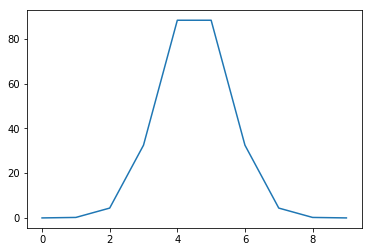

In [2]:
import numpy as np
from scipy.stats import norm as stats_norm

# x input range = (0.0 , 1.0)
def get_soft_one_hot(gsoh_x, gsoh_bit_width=10):
    
    gsoh_x = min(gsoh_x, 1.0)
    gsoh_x = max(gsoh_x, 0.0)

    gsoh_x_scaled = gsoh_x * (gsoh_bit_width-1.0)
    
    gsoh_norm_ratio = 1.0 / stats_norm.pdf(0)
    
    dist_fat_index = 1

    gsoh_out_list = [gsoh_norm_ratio * stats_norm.pdf((gsoh_x_scaled-offset)*(1./dist_fat_index)) for offset in range(gsoh_bit_width)]
    
    gsoh_out_list = [x*100.0 for x in gsoh_out_list]
    
    return(gsoh_out_list)

print ('[info] One Hot function defined.')

# show data as example
test_value = 0.50

print ('[info] Test value: \"{}\".'.format(test_value))
print(['{:.2f}'.format(x) for x in np.array(get_soft_one_hot(test_value))])

plt.plot(np.array(get_soft_one_hot(test_value)))
plt.show()

# define function to load drum data

In [3]:
file_name = 'song_drum_bar_list_46.pkl'
folder_name = './generation_evaluation_dir/cdsed_drum_bar_list_28_46/'
full_file_name = folder_name + file_name
    
with open(full_file_name, 'rb') as pkl_file:
    song_drum_bar_list_46 = pickle.load(pkl_file)

song_idx = 10
bar_idx = 30
total_songs = len(song_drum_bar_list_46)

print(total_songs)
print(song_drum_bar_list_46[song_idx][bar_idx].shape)
print (np.max(song_drum_bar_list_46[song_idx][bar_idx]))
print (np.min(song_drum_bar_list_46[song_idx][bar_idx]))
print (np.round(np.sum(song_drum_bar_list_46[song_idx][bar_idx])))

24
(46, 16)
1.0
0.0
9.0


In [4]:
song_bar_note_num_list = []

for song_idx in range(0, total_songs):
    
    bar_num_in_song = len(song_drum_bar_list_46[song_idx])
    bar_note_num_list = [np.round(np.sum(song_drum_bar_list_46[song_idx][bar_idx])).astype(np.float32) for bar_idx in range(bar_num_in_song)]
    
    song_bar_note_num_list.append(bar_note_num_list)

In [5]:
print(len(song_bar_note_num_list))
print(len(song_bar_note_num_list[10]))
print(song_bar_note_num_list[10][50])

24
140
13.0


# loop over files

In [6]:
print ('[info] Start converstion...')
print ('[info] ' + datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S') + '\n')

all_merged_attribute_list = []

loop_n_files = len(song_bar_note_num_list)

for song_idx in range(0, loop_n_files):
    
    # get soft one hot tempo
    tempo_value = 120
    tempo_norm_v = (tempo_value - 60.0)*(1.0/90.0)
    tempo_norm_v_oh = np.array(get_soft_one_hot(tempo_norm_v))
    
    # get soft one hot style
    style_value = 15
    style_tag_array_oh = np.zeros([16])
    style_tag_array_oh[style_value] = 100.0
    
    n_note_in_bars_ary = np.array(song_bar_note_num_list[song_idx])
    n_bars_in_song = len(song_drum_bar_list_46[song_idx])
    
    # get soft one hot progress value
    progress_ratio_list = [(x+1)/n_bars_in_song for x in range(n_bars_in_song)]
    song_progress_oh = np.array([np.array(get_soft_one_hot(x)) for x in progress_ratio_list])
    
    #drum_arrange_data = get_drum_arrange_data(song_idx)
    
    #all_merged_drum_data = [n_bars_in_song,
    #                        tempo_norm_v_oh,
    #                        style_tag_array_oh,
    #                        song_progress_oh,
    #                        n_note_in_bars_ary,
    #                        drum_arrange_data]
    
    all_merged_drum_data = [n_bars_in_song,
                            tempo_norm_v_oh,
                            style_tag_array_oh,
                            song_progress_oh,
                            n_note_in_bars_ary]
    
    #tempo_value_list.append(tempo_value)
    #style_value_list.append(style_value)
    #note_num_list.append(n_note_in_bars_ary)
    
    all_merged_attribute_list.append(all_merged_drum_data)
    

    if (song_idx+1)%1==0:
        
        print ('[info] Song processed: {}, bars: {}, T: {}, S: {}, P: {}, N: {}'.format(song_idx+1, 
                                                                                        n_bars_in_song, 
                                                                                        tempo_norm_v_oh.shape,
                                                                                        style_tag_array_oh.shape,
                                                                                        song_progress_oh.shape,
                                                                                        n_note_in_bars_ary.shape))
        
        
    #saving_file_name_final = './large_dataset_data/all_merged_data/all_merged_data_{:0>5}.pkl'.format(song_idx)
    #saving_file_name_final = './large_dataset_data/all_merged_data_attribute_only/all_merged_data_atri_{:0>5}.pkl'.format(song_idx)
    
    #with open(saving_file_name_final, 'wb') as pkl_file:
    #    pickle.dump(all_merged_drum_data, pkl_file)
        
        #print (datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))

print ('\n[info] All files are processed.')
print (datetime.datetime.now().strftime('%Y/%m/%d  %H:%M:%S'))

[info] Start converstion...
[info] 2019/03/31  03:03:19

[info] Song processed: 1, bars: 101, T: (10,), S: (16,), P: (101, 10), N: (101,)
[info] Song processed: 2, bars: 81, T: (10,), S: (16,), P: (81, 10), N: (81,)
[info] Song processed: 3, bars: 91, T: (10,), S: (16,), P: (91, 10), N: (91,)
[info] Song processed: 4, bars: 94, T: (10,), S: (16,), P: (94, 10), N: (94,)
[info] Song processed: 5, bars: 86, T: (10,), S: (16,), P: (86, 10), N: (86,)
[info] Song processed: 6, bars: 84, T: (10,), S: (16,), P: (84, 10), N: (84,)
[info] Song processed: 7, bars: 101, T: (10,), S: (16,), P: (101, 10), N: (101,)
[info] Song processed: 8, bars: 91, T: (10,), S: (16,), P: (91, 10), N: (91,)
[info] Song processed: 9, bars: 88, T: (10,), S: (16,), P: (88, 10), N: (88,)
[info] Song processed: 10, bars: 79, T: (10,), S: (16,), P: (79, 10), N: (79,)
[info] Song processed: 11, bars: 140, T: (10,), S: (16,), P: (140, 10), N: (140,)
[info] Song processed: 12, bars: 68, T: (10,), S: (16,), P: (68, 10), N: (

# save all attribute data

In [7]:
file_name = 'bm24_all_attribute.pkl'
folder_name = './evaluatio_10_songs/'
full_file_name = folder_name + file_name
    
with open(full_file_name, 'wb') as pkl_file:
    pickle.dump(all_merged_attribute_list, pkl_file)